In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 13.8 MB/s 
     |████████████████████████████████| 182 kB 64.1 MB/s 
     |████████████████████████████████| 168 kB 55.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 168 kB 71.1 MB/s 
     |████████████████████████████████| 166 kB 70.7 MB/s 
     |████████████████████████████████| 166 kB 76.3 MB/s 
     |████████████████████████████████| 162 kB 72.1 MB/s 
     |████████████████████████████████| 162 kB 73.7 MB/s 
     |████████████████████████████████| 158 kB 74.9 MB/s 
     |████████████████████████████████| 157 kB 68.4 MB/s 
     |████████████████████████████████| 157 kB 72.1 MB/s 
     |████████████████████████████████| 157 kB 73.5 MB/s 
     |████████████████████████████████| 157 kB 69.7 MB/s 
     |████████████████████████████████| 157 kB 75.1 MB/s 
     |████████████████████████████████| 157 kB 73.8 MB/s 
     |████████████████████████████████| 157 kB 73.7 MB/s 
     |██████████

In [2]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

2.2 Fetch and Data Segregation


In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "animals",
  "artifact_name": "animals_raw_data:latest",
}

In [6]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="pablosanttana",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: pablosanttana. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact animals_raw_data:latest, 116.12MB. 5935 files... 
wandb:   5935 of 5935 files downloaded.  
Done. 0:1:11.0
28-11-2022 11:53:59 Path: ./artifacts/animals_raw_data:v0


In [7]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 5935 files belonging to 3 classes.


In [8]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [9]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 186
Number of train batches: 149
Number of validation batches: 30
Number of test batches: 7


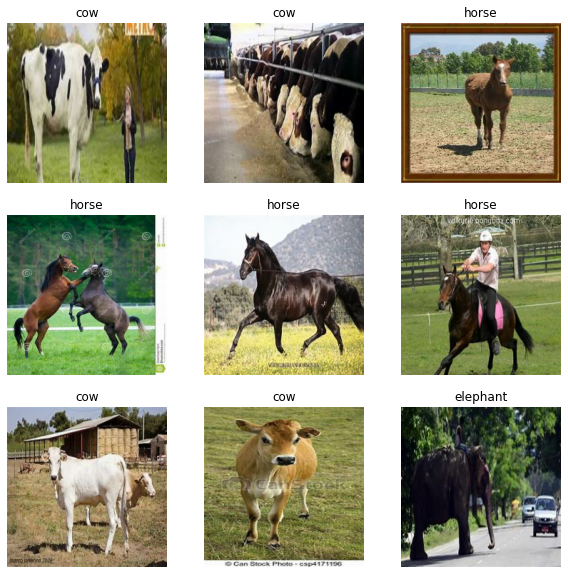

In [10]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

2.3 Configure the dataset for performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Use data augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

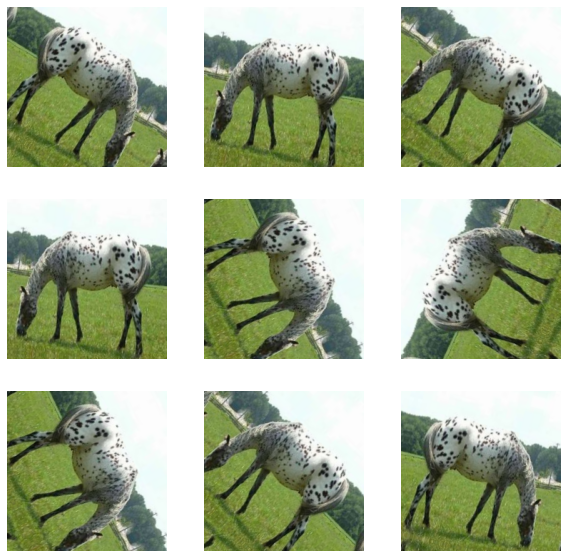

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

 Create the base model from the pre-trained convnets

In [14]:

# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
model = tf.keras.applications.resnet.ResNet101(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

171446536/171446536 [==============================] - 5s 0us/step


In [15]:
model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


Feature extraction

In [17]:
model.trainable = False

Add a classification head

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [19]:
prediction_layer = tf.keras.layers.Dense(3,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [20]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

 Compile the model



In [21]:
# initialize the optimizer and model
learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Train and Evalute the model

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [23]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

Epoch 1/10
149/149 [==============================] - 49s 268ms/step - loss: 0.3426 - accuracy: 0.8640 - val_loss: 0.1365 - val_accuracy: 0.9500
Epoch 2/10
149/149 [==============================] - 40s 258ms/step - loss: 0.1899 - accuracy: 0.9297 - val_loss: 0.1145 - val_accuracy: 0.9604
Epoch 3/10
149/149 [==============================] - 39s 252ms/step - loss: 0.1604 - accuracy: 0.9442 - val_loss: 0.0969 - val_accuracy: 0.9677
Epoch 4/10
149/149 [==============================] - 40s 255ms/step - loss: 0.1537 - accuracy: 0.9432 - val_loss: 0.1075 - val_accuracy: 0.9604
Epoch 5/10
149/149 [==============================] - 39s 252ms/step - loss: 0.1328 - accuracy: 0.9520 - val_loss: 0.0944 - val_accuracy: 0.9646
Epoch 6/10
149/149 [==============================] - 39s 254ms/step - loss: 0.1335 - accuracy: 0.9569 - val_loss: 0.1154 - val_accuracy: 0.9573
Epoch 7/10
149/149 [==============================] - 39s 254ms/step - loss: 0.1306 - accuracy: 0.9465 - val_loss: 0.1168 - val_ac

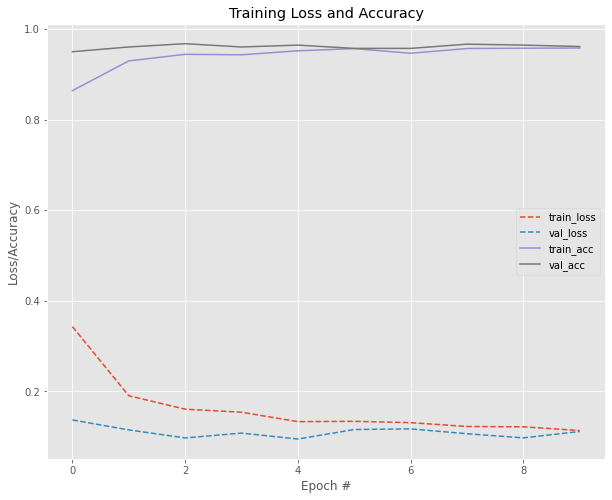

In [24]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [57]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy of the transfer learning with feature extractor": wandb.Image(fig),
    }
)

28-11-2022 13:10:00 Uploading figures


In [25]:
y = np.concatenate([y for x, y in test_dataset], axis=0)
y2 = np.concatenate([y for x, y in test_dataset], axis=0)

In [26]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [27]:
# evaluate the network
print("[INFO] evaluating network...")
print(class_names)
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
['cow', 'elephant', 'horse']
7/7 [==============================] - 3s 164ms/step
              precision    recall  f1-score   support

         cow       0.88      0.97      0.92        69
    elephant       0.95      1.00      0.97        55
       horse       0.99      0.89      0.94       100

    accuracy                           0.94       224
   macro avg       0.94      0.95      0.94       224
weighted avg       0.95      0.94      0.94       224



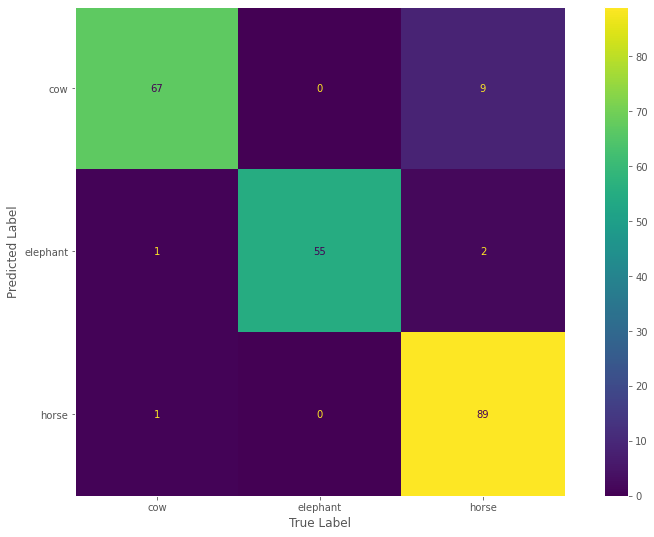

In [28]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(14,9))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [56]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix of the transfer learning with feature extractor": wandb.Image(fig_confusion_matrix),
    }
)

28-11-2022 13:09:55 Uploading figures


Transfer learning with fine-tuning

In [29]:
# import the necessary packages
from tensorflow.keras.applications import ResNet101

# whether or not to include top of CNN
include_top = 0

# load the VGG16 network
print("[INFO] loading network...")
model = ResNet101(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalizat

In [30]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

First Stage

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [32]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.resnet.ResNet101(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [33]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [34]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
Total params: 42,658,176
Trainable params: 42,552,832
Non-t

In [35]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [36]:
# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=base_model.input, outputs=headModel)

In [37]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [38]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [39]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in model.layers[4].layers:
	layer.trainable = False

In [40]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [41]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [42]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

[INFO] training head...
Epoch 1/10
149/149 [==============================] - 49s 280ms/step - loss: 5.0702 - accuracy: 0.8019 - val_loss: 0.2279 - val_accuracy: 0.9385
Epoch 2/10
149/149 [==============================] - 41s 263ms/step - loss: 0.7388 - accuracy: 0.8752 - val_loss: 0.3393 - val_accuracy: 0.9469
Epoch 3/10
149/149 [==============================] - 40s 261ms/step - loss: 0.6614 - accuracy: 0.8975 - val_loss: 0.1743 - val_accuracy: 0.9573
Epoch 4/10
149/149 [==============================] - 41s 266ms/step - loss: 0.6342 - accuracy: 0.9032 - val_loss: 0.3101 - val_accuracy: 0.9354
Epoch 5/10
149/149 [==============================] - 41s 262ms/step - loss: 0.6007 - accuracy: 0.9135 - val_loss: 0.2532 - val_accuracy: 0.9479
Epoch 6/10
149/149 [==============================] - 41s 262ms/step - loss: 0.4923 - accuracy: 0.9166 - val_loss: 0.3402 - val_accuracy: 0.9583
Epoch 7/10
149/149 [==============================] - 41s 262ms/step - loss: 0.4510 - accuracy: 0.9253 - v

Second Stage

In [43]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	SlicingOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [44]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	ZeroPadding2D
[INFO] 2	Conv2D
[INFO] 3	BatchNormalization
[INFO] 4	Activation
[INFO] 5	ZeroPadding2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	Activation
[INFO] 10	Conv2D
[INFO] 11	BatchNormalization
[INFO] 12	Activation
[INFO] 13	Conv2D
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	BatchNormalization
[INFO] 17	Add
[INFO] 18	Activation
[INFO] 19	Conv2D
[INFO] 20	BatchNormalization
[INFO] 21	Activation
[INFO] 22	Conv2D
[INFO] 23	BatchNormalization
[INFO] 24	Activation
[INFO] 25	Conv2D
[INFO] 26	BatchNormalization
[INFO] 27	Add
[INFO] 28	Activation
[INFO] 29	Conv2D
[INFO] 30	BatchNormalization
[INFO] 31	Activation
[INFO] 32	Conv2D
[INFO] 33	BatchNormalization
[INFO] 34	Activation
[INFO] 35	Conv2D
[INFO] 36	BatchNormalization
[INFO] 37	Add
[INFO] 38	Activation
[INFO] 39	Conv2D
[INFO] 40	BatchNormalization
[INFO] 41	Activation
[INFO] 42	Conv2D
[INFO] 43	BatchNormalization
[INFO] 44	Activation
[INFO] 45	Conv2D
[INFO] 46

In [45]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [46]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in model.layers[4].layers[15:]:
	layer.trainable = True

In [47]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0   

In [48]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [49]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] training head...")
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

[INFO] training head...
Epoch 1/10
149/149 [==============================] - 108s 643ms/step - loss: 0.3166 - accuracy: 0.9148 - val_loss: 0.1618 - val_accuracy: 0.9563
Epoch 2/10
149/149 [==============================] - 94s 623ms/step - loss: 0.1726 - accuracy: 0.9455 - val_loss: 0.1103 - val_accuracy: 0.9698
Epoch 3/10
149/149 [==============================] - 94s 623ms/step - loss: 0.1304 - accuracy: 0.9619 - val_loss: 0.1025 - val_accuracy: 0.9740
Epoch 4/10
149/149 [==============================] - 94s 622ms/step - loss: 0.1246 - accuracy: 0.9638 - val_loss: 0.1038 - val_accuracy: 0.9719
Epoch 5/10
149/149 [==============================] - 94s 623ms/step - loss: 0.1065 - accuracy: 0.9655 - val_loss: 0.0948 - val_accuracy: 0.9719
Epoch 6/10
149/149 [==============================] - 94s 622ms/step - loss: 0.0984 - accuracy: 0.9682 - val_loss: 0.0881 - val_accuracy: 0.9677
Epoch 7/10
149/149 [==============================] - 94s 622ms/step - loss: 0.0886 - accuracy: 0.9705 - 

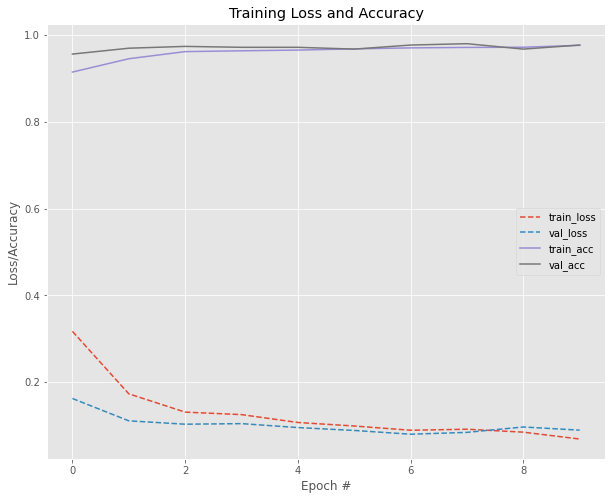

In [50]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [55]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "Training Loss and Accuracy transfer learning with fine tuning": wandb.Image(fig),
    }
)

28-11-2022 13:09:42 Uploading figures


In [51]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [52]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
7/7 [==============================] - 7s 180ms/step
              precision    recall  f1-score   support

         cow       0.99      0.92      0.95        74
    elephant       0.96      1.00      0.98        50
       horse       0.96      0.99      0.98       100

    accuracy                           0.97       224
   macro avg       0.97      0.97      0.97       224
weighted avg       0.97      0.97      0.97       224



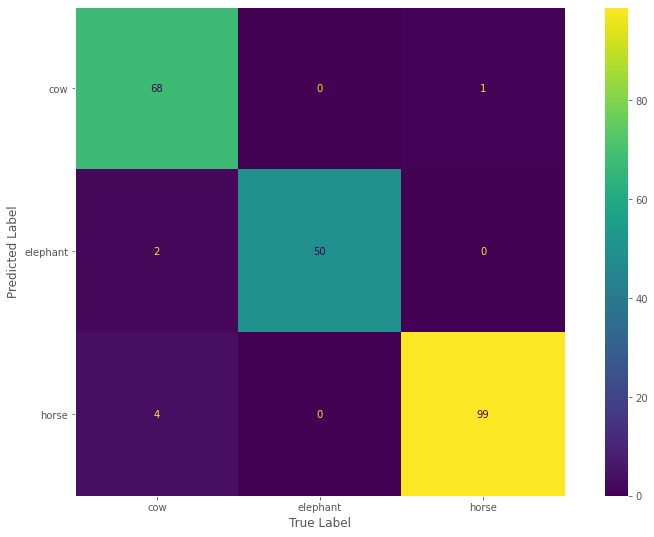

In [53]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(14,9))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [54]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix transfer learning with fine tuning": wandb.Image(fig_confusion_matrix),
    }
)

28-11-2022 13:09:36 Uploading figures


In [ ]:
run.finish()